In [1]:
# Efflux / Reflux (Cokelet & Stewart, 1985)
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [2]:
# Find the interface and vertical flux of theta
def Layer(u):
    # Layer interface, zero velocity crossing point
    uzx = u.mean(axis=(0,2)) # Z, X
    Xu = uzx.shape[1]
    itf = np.empty(Xu, dtype=int)
    itf[[0,1,-2,-1]] = 0 # Remove data at fjord head and end
    for i in range(2,Xu-2):
        l = np.where(uzx[:, i] < 0)[-1][0]
        itf[i] = l
    return itf

In [4]:
def FluxCoef(sd):
    state01 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/Sills/state_' + str(format(sd,'03d')) + '.nc')
    state02 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/Sills/grid_' + str(format(sd,'03d')) + '.nc')
    state1 = state01.isel(Y=range(1,10), T=range(40,121))
    
    
    u = state1.U.data
    w = state1.W.data
    temp = state1.Temp.data
    
    Area = np.empty([50, 9]) # Cross Y direction
    Area[:10, :] = 100
    Area[10:20, :] = 200
    Area[20:30, :] = 300
    Area[30:40, :] = 800
    Area[40:, :] = 1600

    f = 52
    s = 66
    HFacW = state02.HFacW.data[:,1:-1,f:s+1] # vertical fraction of open cell at West face
    rA = state02.rA.data[1:-1,f:s+1] # r face area at cell center
    itf = Layer(u)
    Vx1 = np.empty(s-f+1) # Horizontal volume transport for the upper layer
    Vx2 = np.empty(s-f+1) # Horizontal volume transport for the lower layer
    Vz = np.empty(s-f+1) # Vertical volume transport through the interface
    for i in range(s-f+1):
        it = itf[f:s+1]
        ut = u[:,:,:,f:s+1].mean(0)
        wt = w[:,:,:,f:s+1].mean(0)
        Vx1[i] = np.sum(ut[:it[i],:,i] * HFacW[:it[i],:,i] * Area[:it[i],:])
        Vx2[i] = np.sum(ut[it[i]:,:,i] * HFacW[it[i]:,:,i] * Area[it[i]:,:])
        Vz[i] = np.sum(wt[it[i],:,i] * rA[:,i])
     
    Q1 = -Vx2[-1]
    Q2 = Vx1[-1]
    Q3 = -Vx2[0]
    Q4 = Vx1[0]
    alph34 = (Q3-Q1)/Q4
    alph24 = Q2 / Q4
    Qr = Q4 - Q2
    Qe = 0.5 * Q4 + 0.5 * Q1
    return (alph24, alph34, Q3, Qe)

In [21]:
hs = np.array([8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22]) # Sill depth [8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 30, 110, 150]
hsr = hs / 150

a24 = np.empty(len(hs))
a34 = np.empty(len(hs))
Q3 = np.empty(len(hs))
Q3e = np.empty(len(hs))
for j in range(len(hs)):
    alph24, alph34, q, qe = FluxCoef(hs[j])
    a24[j] = alph24
    a34[j] = alph34
    Q3[j] = q
    Q3e[j] = qe
    
a24, a34

(array([0.32074128, 0.35906647, 0.40080784, 0.4533872 , 0.51907612,
        0.5629233 , 0.61984259, 0.64369879, 0.69051709, 0.77887909,
        0.8649211 , 0.96275573]),
 array([0.67926795, 0.64093691, 0.59919465, 0.54662246, 0.48094441,
        0.43707947, 0.3801782 , 0.35629755, 0.30948857, 0.22112369,
        0.13507459, 0.03725773]))

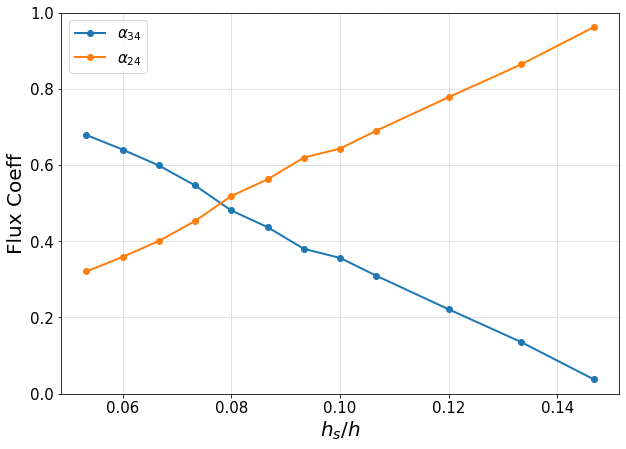

In [28]:
fig1, ax =plt.subplots(figsize=(10,7))
      
ax.set(ylim=(0, 1))
#plt.axis('square')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$h_s/h$', size=20)
plt.ylabel(r'Flux Coeff', size=20)
ax.plot(hsr, a34, 'o-', lw=2, label=r'$\alpha_{34}$')
ax.plot(hsr, a24, 'o-', lw=2, label=r'$\alpha_{24}$')
ax.legend(loc = 'best', fontsize=15)
ax.grid(linestyle='--', linewidth='0.5')

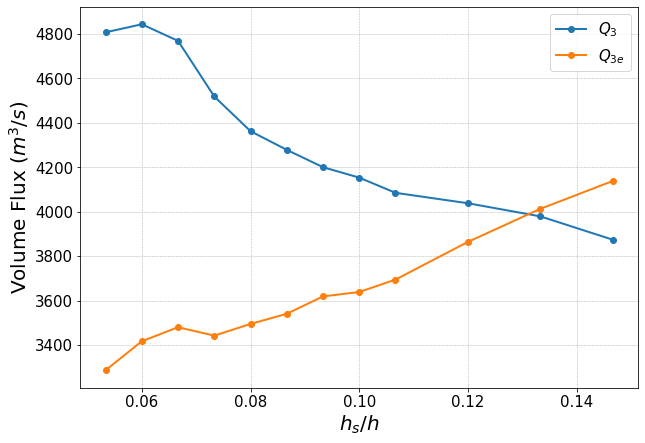

In [31]:
fig2, ax =plt.subplots(figsize=(10,7))
      
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$h_s/h$', size=20)
plt.ylabel(r'Volume Flux $(m^3/s)$', size=20)
ax.plot(hsr, Q3, 'o-', lw=2, label=r'$Q_3$')
ax.plot(hsr, Q3e, 'o-', lw=2, label=r'$Q_{3e}$')
ax.legend(loc = 'best', fontsize=15)
ax.grid(linestyle='--', linewidth='0.5')

In [33]:
fig_path = "/Users/weiyangbao/Documents/Jupyter_Figs/Transport/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig2.savefig(fig_path + '/entropy.png', dpi = 150, bbox_inches='tight')